In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
four_labels = torch.tensor([0,0,1,1])
four_pred = torch.tensor([2.0, -3.5, -1.0, 1.5])

---

In this notebook I transformed the ROC curve code to the PR curve code (like what I previously did in R).  
I also studied the difference in the results when we use different values for the precision in the case where (TP+FP)=0.

---

# ROC

The following ROC codes can be found [here.](https://tdhock.github.io/blog/2024/torch-roc-aum/)

In [3]:
def ROC_curve(pred_tensor, label_tensor):
    """Receiver Operating Characteristic curve.
    """
    is_positive = label_tensor == 1
    is_negative = label_tensor != 1
    fn_diff = torch.where(is_positive, -1, 0)
    fp_diff = torch.where(is_positive, 0, 1)
    thresh_tensor = -pred_tensor.flatten()
    sorted_indices = torch.argsort(thresh_tensor)
    fp_denom = torch.sum(is_negative) #or 1 for AUM based on count instead of rate
    fn_denom = torch.sum(is_positive) #or 1 for AUM based on count instead of rate
    sorted_fp_cum = fp_diff[
        sorted_indices].cumsum(axis=0)/fp_denom
    sorted_fn_cum = -fn_diff[
        sorted_indices].flip(0).cumsum(axis=0).flip(0)/fn_denom
    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True])])
    sorted_fn_end = torch.cat([torch.tensor([True]), sorted_is_diff])
    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]
    FPR = torch.cat([torch.tensor([0.0]), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0])])
    return {
        "FPR":FPR,
        "FNR":FNR,
        "TPR":1 - FNR,
        "min(FPR,FNR)":torch.minimum(FPR, FNR),
        "min_constant":torch.cat([torch.tensor([-torch.inf]), uniq_thresh]),
        "max_constant":torch.cat([uniq_thresh, torch.tensor([torch.inf])])
    }
roc_efficient_df = pd.DataFrame(ROC_curve(four_pred, four_labels))
roc_efficient_df

,FPR,FNR,TPR,"min(FPR,FNR)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,-inf,-2.0
1,0.5,1.0,0.0,0.5,-2.0,-1.5
2,0.5,0.5,0.5,0.5,-1.5,1.0
3,0.5,0.0,1.0,0.0,1.0,3.5
4,1.0,0.0,1.0,0.0,3.5,inf


In [4]:
def ROC_AUC(pred_tensor, label_tensor):
    roc = ROC_curve(pred_tensor, label_tensor)
    FPR_diff = roc["FPR"][1:]-roc["FPR"][:-1]
    TPR_sum = roc["TPR"][1:]+roc["TPR"][:-1]
    
    print(roc["FPR"][1:])
    print(roc["FPR"][:-1])
    print(roc["TPR"][1:])
    print(roc["TPR"][:-1])
    
    return torch.sum(FPR_diff*TPR_sum/2.0)
ROC_AUC(four_pred, four_labels)

tensor([0.5000, 0.5000, 0.5000, 1.0000])
tensor([0.0000, 0.5000, 0.5000, 0.5000])
tensor([0.0000, 0.5000, 1.0000, 1.0000])
tensor([0.0000, 0.0000, 0.5000, 1.0000])


tensor(0.5000)

In [5]:
pred_dict = {
    "ideal":[1.0, 2, 3, 4],
    "constant":[9.0, 9, 9, 9],
    "anti-learning":[4.0, 3, 2, 1],
}
example_pred_df = pd.DataFrame(pred_dict)
example_pred_df["label"] = four_labels
example_pred_df

,ideal,constant,anti-learning,label
0,1.0,9.0,4.0,0
1,2.0,9.0,3.0,0
2,3.0,9.0,2.0,1
3,4.0,9.0,1.0,1


In [6]:
def Proposed_AUM(pred_tensor, label_tensor):
    """Area Under Min(FP,FN)

    Differentiable loss function for imbalanced binary classification
    problems. Minimizing AUM empirically results in maximizing Area
    Under the ROC Curve (AUC). Arguments: pred_tensor and label_tensor
    should both be 1d tensors, vectors of real-valued predictions and
    integer labels for each observation in the set/batch. Labels
    should be either 1 for positive class or any other value for
    negative class.

    """
    roc = ROC_curve(pred_tensor, label_tensor)
    min_FPR_FNR = roc["min(FPR,FNR)"][1:-1]
    constant_diff = roc["min_constant"][1:].diff()
    return torch.sum(min_FPR_FNR * constant_diff)

In [7]:
Proposed_AUM(four_pred, four_labels)

tensor(1.5000)

---

---

# Precision-Recall

Here are the results I found in R.

![title](../Figures/Fig-Week2-PR-R-results.png)

---

## SCIKIT LEARN

First I used the **precision_recall_curve** function from scikit learn to confirm my results.

[Documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)  
From the scikit learn website :   
*Precision : ndarray of shape (n_thresholds + 1,)  
Precision values such that element i is the precision of predictions with score >= thresholds[i] and the last element is 1.*

In [8]:
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([2.0, -3.5, -1.0, 1.5])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

print("Precision:", precision)
print("Recall:", recall)

Precision: [0.5        0.66666667 0.5        0.         1.        ]
Recall: [1.  1.  0.5 0.  0. ]


The results using scikit learn are the same (reading from right to left) as the one from R (reading top to bottom) except the value of the precision when its denominator is equal to 0. The scikit learn function set the precision value to **1**

---

## CURVE

I did three function for the PR curve, they all set a different value for the precision in the case where its denominator is equal to zero.
- **PR_curve** : precision = NaN
- **PR_curve_0** : precision = 0
- **PR_curve_1** : precision = 1

In [9]:
def PR_curve(pred_tensor, label_tensor):
    """Precision-Recall curve.
    """
    is_positive = label_tensor == 1
    is_negative = label_tensor != 1
    fn_diff = torch.where(is_positive, -1, 0)
    fp_diff = torch.where(is_positive, 0, 1)
    thresh_tensor = -pred_tensor.flatten()
    sorted_indices = torch.argsort(thresh_tensor)
    fp_denom = torch.sum(is_negative) #or 1 for AUM based on count instead of rate
    fn_denom = torch.sum(is_positive) #or 1 for AUM based on count instead of rate
    sorted_fp_cum = fp_diff[
        sorted_indices].cumsum(axis=0)/fp_denom
    sorted_fn_cum = -fn_diff[
        sorted_indices].flip(0).cumsum(axis=0).flip(0)/fn_denom
    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True])])
    sorted_fn_end = torch.cat([torch.tensor([True]), sorted_is_diff])
    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]
    
    
    
    FPR = torch.cat([torch.tensor([0.0]), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0])])
    total_positives = torch.sum(is_positive)
    total_negatives = torch.sum(is_negative)
    TP = total_positives * (1 - FNR)
    TN = total_negatives * (1 - FPR)
    FP = total_negatives * FPR
    FN = total_positives * FNR
    
    precision = torch.zeros_like(TP)
    recall = torch.zeros_like(TP)
    valid_precision = (TP + FP) != 0
    valid_recall = (TP + FN) != 0
    precision[valid_precision] = (TP / (TP + FP))[valid_precision]
    precision[~valid_precision] = float('nan')
    recall[valid_recall] = (TP / (TP + FN))[valid_recall]
    recall[~valid_recall] = float('nan')
    
    min_pre_rec = torch.minimum(1-precision, 1-recall)
    
    return {
        "FPR": FPR,
        "FNR": FNR,
        "TPR": 1 - FNR,
        "recall": recall,
        "precision": precision,
        "min(pre,rec)": min_pre_rec,  # Correction 3
        "min_constant": torch.cat([torch.tensor([-torch.inf]), uniq_thresh]),
        "max_constant": torch.cat([uniq_thresh, torch.tensor([torch.inf])])
    }

In [10]:
def PR_curve_0(pred_tensor, label_tensor):
    """Precision-Recall curve.
    """
    is_positive = label_tensor == 1
    is_negative = label_tensor != 1
    fn_diff = torch.where(is_positive, -1, 0)
    fp_diff = torch.where(is_positive, 0, 1)
    thresh_tensor = -pred_tensor.flatten()
    sorted_indices = torch.argsort(thresh_tensor)
    fp_denom = torch.sum(is_negative) #or 1 for AUM based on count instead of rate
    fn_denom = torch.sum(is_positive) #or 1 for AUM based on count instead of rate
    sorted_fp_cum = fp_diff[
        sorted_indices].cumsum(axis=0)/fp_denom
    sorted_fn_cum = -fn_diff[
        sorted_indices].flip(0).cumsum(axis=0).flip(0)/fn_denom
    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True])])
    sorted_fn_end = torch.cat([torch.tensor([True]), sorted_is_diff])
    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]
    
    
    
    FPR = torch.cat([torch.tensor([0.0]), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0])])
    total_positives = torch.sum(is_positive)
    total_negatives = torch.sum(is_negative)
    TP = total_positives * (1 - FNR)
    TN = total_negatives * (1 - FPR)
    FP = total_negatives * FPR
    FN = total_positives * FNR
    
    precision = torch.zeros_like(TP)
    recall = torch.zeros_like(TP)
    valid_precision = (TP + FP) != 0
    valid_recall = (TP + FN) != 0
    precision[valid_precision] = (TP / (TP + FP))[valid_precision]
    precision[~valid_precision] = 0
    recall[valid_recall] = (TP / (TP + FN))[valid_recall]
    recall[~valid_recall] = 0
    
    min_pre_rec = torch.minimum(1-precision, 1-recall)
    
    return {
        "FPR": FPR,
        "FNR": FNR,
        "TPR": 1 - FNR,
        "recall": recall,
        "precision": precision,
        "min(pre,rec)": min_pre_rec,  # Correction 3
        "min_constant": torch.cat([torch.tensor([-torch.inf]), uniq_thresh]),
        "max_constant": torch.cat([uniq_thresh, torch.tensor([torch.inf])])
    }

In [11]:
def PR_curve_1(pred_tensor, label_tensor):
    """Precision-Recall curve.
    """
    is_positive = label_tensor == 1
    is_negative = label_tensor != 1
    fn_diff = torch.where(is_positive, -1, 0)
    fp_diff = torch.where(is_positive, 0, 1)
    thresh_tensor = -pred_tensor.flatten()
    sorted_indices = torch.argsort(thresh_tensor)
    fp_denom = torch.sum(is_negative) #or 1 for AUM based on count instead of rate
    fn_denom = torch.sum(is_positive) #or 1 for AUM based on count instead of rate
    sorted_fp_cum = fp_diff[
        sorted_indices].cumsum(axis=0)/fp_denom
    sorted_fn_cum = -fn_diff[
        sorted_indices].flip(0).cumsum(axis=0).flip(0)/fn_denom
    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True])])
    sorted_fn_end = torch.cat([torch.tensor([True]), sorted_is_diff])
    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]
    
    
    
    FPR = torch.cat([torch.tensor([0.0]), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0])])
    total_positives = torch.sum(is_positive)
    total_negatives = torch.sum(is_negative)
    TP = total_positives * (1 - FNR)
    TN = total_negatives * (1 - FPR)
    FP = total_negatives * FPR
    FN = total_positives * FNR
    
    precision = torch.zeros_like(TP)
    recall = torch.zeros_like(TP)
    valid_precision = (TP + FP) != 0
    valid_recall = (TP + FN) != 0
    precision[valid_precision] = (TP / (TP + FP))[valid_precision]
    precision[~valid_precision] = 1
    recall[valid_recall] = (TP / (TP + FN))[valid_recall]
    recall[~valid_recall] = 1
    
    min_pre_rec = torch.minimum(1-precision, 1-recall)
    
    return {
        "FPR": FPR,
        "FNR": FNR,
        "TPR": 1 - FNR,
        "recall": recall,
        "precision": precision,
        "min(pre,rec)": min_pre_rec,  # Correction 3
        "min_constant": torch.cat([torch.tensor([-torch.inf]), uniq_thresh]),
        "max_constant": torch.cat([uniq_thresh, torch.tensor([torch.inf])])
    }

In [12]:
pr_efficient_df = pd.DataFrame(PR_curve(four_pred, four_labels))
pr_efficient_df

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,NaN,NaN,-inf,-2.0
1,0.5,1.0,0.0,0.0,0.000000,1.0,-2.0,-1.5
2,0.5,0.5,0.5,0.5,0.500000,0.5,-1.5,1.0
3,0.5,0.0,1.0,1.0,0.666667,0.0,1.0,3.5
4,1.0,0.0,1.0,1.0,0.500000,0.0,3.5,inf


In [13]:
pr_efficient_df_0 = pd.DataFrame(PR_curve_0(four_pred, four_labels))
pr_efficient_df_0

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,0.000000,1.0,-inf,-2.0
1,0.5,1.0,0.0,0.0,0.000000,1.0,-2.0,-1.5
2,0.5,0.5,0.5,0.5,0.500000,0.5,-1.5,1.0
3,0.5,0.0,1.0,1.0,0.666667,0.0,1.0,3.5
4,1.0,0.0,1.0,1.0,0.500000,0.0,3.5,inf


In [14]:
pr_efficient_df_1 = pd.DataFrame(PR_curve_1(four_pred, four_labels))
pr_efficient_df_1

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,1.000000,0.0,-inf,-2.0
1,0.5,1.0,0.0,0.0,0.000000,1.0,-2.0,-1.5
2,0.5,0.5,0.5,0.5,0.500000,0.5,-1.5,1.0
3,0.5,0.0,1.0,1.0,0.666667,0.0,1.0,3.5
4,1.0,0.0,1.0,1.0,0.500000,0.0,3.5,inf


---

## AUC

In [15]:
def PR_AUC(pred_tensor, label_tensor):
    pr = PR_curve(pred_tensor, label_tensor)
    recall_diff = pr["recall"][1:]-pr["recall"][:-1]
    precision_sum = pr["precision"][1:]+pr["precision"][:-1]
    
    print(pr["recall"][1:])
    print(pr["recall"][:-1])
    print(pr["precision"][1:])
    print(pr["precision"][:-1])
    
    return torch.sum(recall_diff*precision_sum/2.0)
PR_AUC(four_pred, four_labels)

tensor([0.0000, 0.5000, 1.0000, 1.0000])
tensor([0.0000, 0.0000, 0.5000, 1.0000])
tensor([0.0000, 0.5000, 0.6667, 0.5000])
tensor([   nan, 0.0000, 0.5000, 0.6667])


tensor(nan)

If we take all the values of the precision and recall when we use NaN in the case where (TP+FP)=0 we can't compute the value of the AUC.  
That is why I made the choice to compute the AUC without that first line so we onlt have numerical values for the computations.

In [16]:
def PR_AUC(pred_tensor, label_tensor):
    pr = PR_curve(pred_tensor, label_tensor)
    recall_diff = pr["recall"][2:]-pr["recall"][1:4]
    precision_sum = pr["precision"][2:]+pr["precision"][1:4]
    
    #print(pr["recall"][2:])
    #print(pr["recall"][1:4])
    #print(pr["precision"][2:])
    #print(pr["precision"][1:4])
    
    return torch.sum(recall_diff*precision_sum/2.0)

In [17]:
def PR_AUC_0(pred_tensor, label_tensor):
    pr = PR_curve_0(pred_tensor, label_tensor)
    recall_diff = pr["recall"][1:]-pr["recall"][:-1]
    precision_sum = pr["precision"][1:]+pr["precision"][:-1]
    
    #print(pr["recall"][1:])
    #print(pr["recall"][:-1])
    #print(pr["precision"][1:])
    #print(pr["precision"][:-1])
    
    return torch.sum(recall_diff*precision_sum/2.0)

In [18]:
def PR_AUC_1(pred_tensor, label_tensor):
    pr = PR_curve_1(pred_tensor, label_tensor)
    recall_diff = pr["recall"][1:]-pr["recall"][:-1]
    precision_sum = pr["precision"][1:]+pr["precision"][:-1]
    
    #print(pr["recall"][1:])
    #print(pr["recall"][:-1])
    #print(pr["precision"][1:])
    #print(pr["precision"][:-1])
    
    return torch.sum(recall_diff*precision_sum/2.0)

In [19]:
PR_AUC(four_pred, four_labels), PR_AUC_0(four_pred, four_labels), PR_AUC_1(four_pred, four_labels)

(tensor(0.4167), tensor(0.4167), tensor(0.4167))

In this case the AUC is the same no matter what we set the value of the precision when its dominator is equal to zero.

---

## AUC plots

In [20]:
pr = PR_curve(four_pred, four_labels)
pr_0 = PR_curve_0(four_pred, four_labels)
pr_1 = PR_curve_1(four_pred, four_labels)

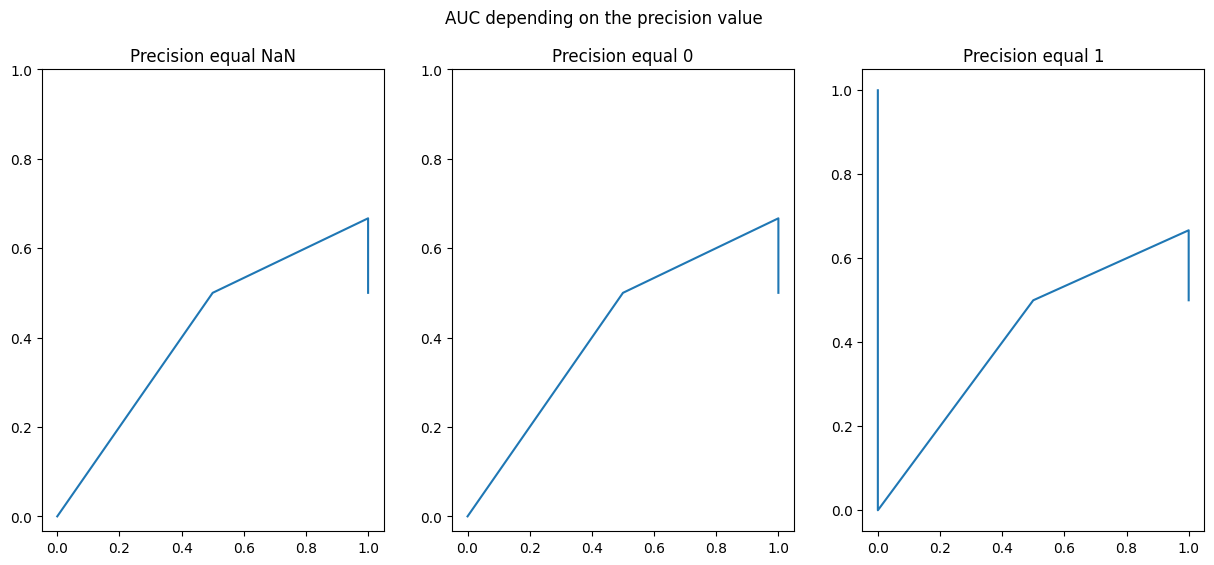

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('AUC depending on the precision value')

ax1.plot(pr["recall"][1:], pr["precision"][1:])
ax1.set_title('Precision equal NaN')
ax1.set_xticks(np.arange(0, 1.1, 0.2))
ax1.set_yticks(np.arange(0, 1.1, 0.2))

ax2.plot(pr_0["recall"][0:], pr_0["precision"][0:])
ax2.set_title('Precision equal 0')
ax2.set_xticks(np.arange(0, 1.1, 0.2))
ax2.set_yticks(np.arange(0, 1.1, 0.2))

ax3.plot(pr_1["recall"][0:], pr_1["precision"][0:])
ax3.set_title('Precision equal 1')
ax3.set_xticks(np.arange(0, 1.1, 0.2))
ax3.set_yticks(np.arange(0, 1.1, 0.2))

---

## AUM

In [22]:
def Proposed_AUM(pred_tensor, label_tensor):
    pr = PR_curve(pred_tensor, label_tensor)
    min_pre_rec = pr["min(pre,rec)"][1:-1]
    constant_diff = pr["min_constant"][1:].diff()
    return torch.sum(min_pre_rec * constant_diff)

In [23]:
def Proposed_AUM_0(pred_tensor, label_tensor):
    pr = PR_curve_0(pred_tensor, label_tensor)
    min_pre_rec = pr["min(pre,rec)"][1:-1]
    constant_diff = pr["min_constant"][1:].diff()
    return torch.sum(min_pre_rec * constant_diff)

In [24]:
def Proposed_AUM_1(pred_tensor, label_tensor):
    pr = PR_curve_1(pred_tensor, label_tensor)
    min_pre_rec = pr["min(pre,rec)"][1:-1]
    constant_diff = pr["min_constant"][1:].diff()
    return torch.sum(min_pre_rec * constant_diff)

In [25]:
Proposed_AUM(four_pred, four_labels), Proposed_AUM_0(four_pred, four_labels), Proposed_AUM_1(four_pred, four_labels)

(tensor(1.7500), tensor(1.7500), tensor(1.7500))

As expected, the results are the same as the ones using R.

---

---

# Second Data

In [26]:
four_labels = torch.tensor([-1, -1, 1, 1])
four_pred = torch.tensor([0.1, 0.4, 0.35, 0.8])

#This is the example used in the precision_recall_curve page on the scikit learn website.
#With those values the AUC changes drastically depending on the value chosen for precision when its dominator is equal to 0

In [27]:
pr_efficient_df = pd.DataFrame(PR_curve(four_pred, four_labels))
pr_efficient_df

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,NaN,NaN,-inf,-0.80
1,0.0,0.5,0.5,0.5,1.000000,0.0,-0.80,-0.40
2,0.5,0.5,0.5,0.5,0.500000,0.5,-0.40,-0.35
3,0.5,0.0,1.0,1.0,0.666667,0.0,-0.35,-0.10
4,1.0,0.0,1.0,1.0,0.500000,0.0,-0.10,inf


In [28]:
pr_efficient_df_0 = pd.DataFrame(PR_curve_0(four_pred, four_labels))
pr_efficient_df_0

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,0.000000,1.0,-inf,-0.80
1,0.0,0.5,0.5,0.5,1.000000,0.0,-0.80,-0.40
2,0.5,0.5,0.5,0.5,0.500000,0.5,-0.40,-0.35
3,0.5,0.0,1.0,1.0,0.666667,0.0,-0.35,-0.10
4,1.0,0.0,1.0,1.0,0.500000,0.0,-0.10,inf


In [29]:
pr_efficient_df_1 = pd.DataFrame(PR_curve_1(four_pred, four_labels))
pr_efficient_df_1

,FPR,FNR,TPR,recall,precision,"min(pre,rec)",min_constant,max_constant
0,0.0,1.0,0.0,0.0,1.000000,0.0,-inf,-0.80
1,0.0,0.5,0.5,0.5,1.000000,0.0,-0.80,-0.40
2,0.5,0.5,0.5,0.5,0.500000,0.5,-0.40,-0.35
3,0.5,0.0,1.0,1.0,0.666667,0.0,-0.35,-0.10
4,1.0,0.0,1.0,1.0,0.500000,0.0,-0.10,inf


---

In [30]:
PR_AUC(four_pred, four_labels), PR_AUC_0(four_pred, four_labels), PR_AUC_1(four_pred, four_labels)

(tensor(0.2917), tensor(0.5417), tensor(0.7917))

In [31]:
pr = PR_curve(four_pred, four_labels)
pr_0 = PR_curve_0(four_pred, four_labels)
pr_1 = PR_curve_1(four_pred, four_labels)

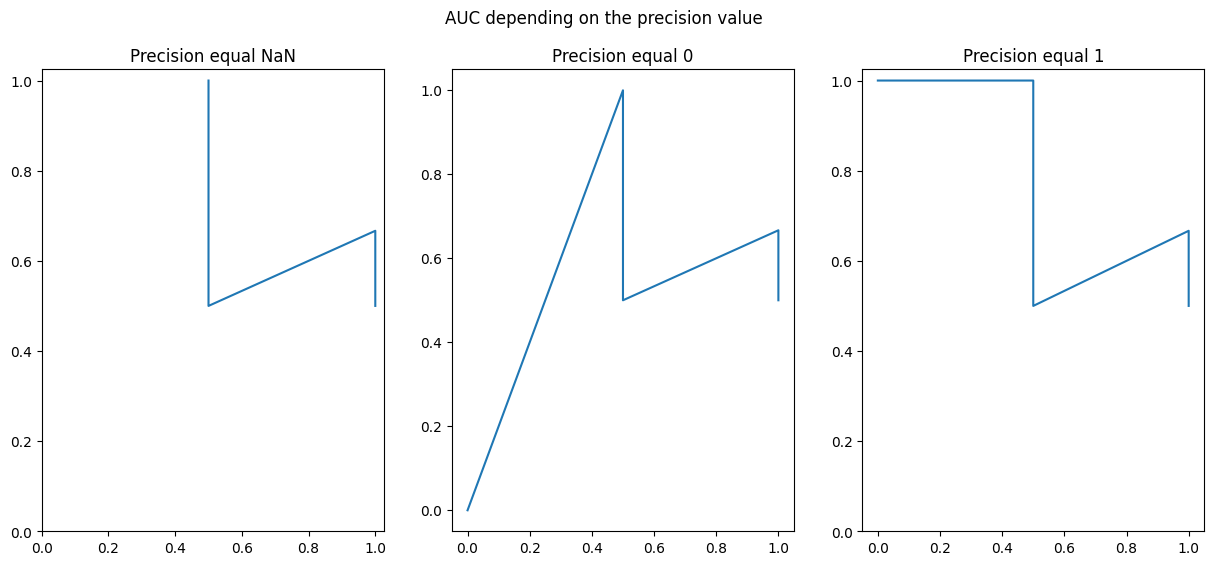

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('AUC depending on the precision value')

ax1.plot(pr["recall"][1:], pr["precision"][1:])
ax1.set_title('Precision equal NaN')
ax1.set_xticks(np.arange(0, 1.1, 0.2))
ax1.set_yticks(np.arange(0, 1.1, 0.2))

ax2.plot(pr_0["recall"][0:], pr_0["precision"][0:])
ax2.set_title('Precision equal 0')
ax2.set_xticks(np.arange(0, 1.1, 0.2))
ax2.set_yticks(np.arange(0, 1.1, 0.2))

ax3.plot(pr_1["recall"][0:], pr_1["precision"][0:])
ax3.set_title('Precision equal 1')
ax3.set_xticks(np.arange(0, 1.1, 0.2))
ax3.set_yticks(np.arange(0, 1.1, 0.2))

In [33]:
Proposed_AUM(four_pred, four_labels), Proposed_AUM_0(four_pred, four_labels), Proposed_AUM_1(four_pred, four_labels)

(tensor(0.0250), tensor(0.0250), tensor(0.0250))